## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv


In [ ]:
train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [ ]:
y_data = train["label"].values
x_data = train.drop(["label"],axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size = 0.2, random_state = 42)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = (x_train.astype(np.float32)-127.5)/127.5

print(x_train.shape)
print(x_test.shape)

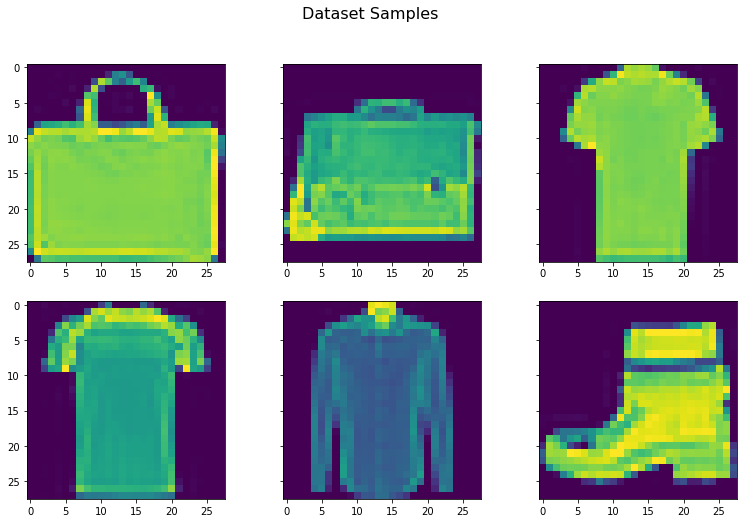

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8), sharey=True)

axs[0,0].imshow(x_test.reshape(12000,28,28)[1])

axs[0,1].imshow(x_test.reshape(12000,28,28)[2])

axs[0,2].imshow(x_test.reshape(12000,28,28)[11])

axs[1,0].imshow(x_test.reshape(12000,28,28)[101])

axs[1,1].imshow(x_test.reshape(12000,28,28)[7000])

axs[1,2].imshow(x_test.reshape(12000,28,28)[11000])
fig.suptitle("Dataset Samples",fontsize=16)

plt.show()

## Generator


In [ ]:
def create_generator():

    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())

    generator.add(Dense(units = 512))
    generator.add(ReLU())

    generator.add(Dense(units = 1024))
    generator.add(ReLU())

    generator.add(Dense(units = 1024))
    generator.add(ReLU())

    generator.add(Dense(units = 784))

    generator.compile(loss ="binary_crossentropy",
                     optimizer = Adam(lr = 0.0001, beta_1 = 0.5))

    return generator

g = create_generator()
g.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               51712     
_________________________________________________________________
re_lu_8 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
re_lu_9 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              525312    
_________________________________________________________________
re_lu_10 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)             

## Discriminator

In [ ]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024,input_dim = 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units = 512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units = 256))
    discriminator.add(ReLU())

    discriminator.add(Dense(units = 1, activation = "sigmoid"))

    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              803840    
_________________________________________________________________
re_lu_12 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
re_lu_13 (ReLU)              (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)              

## GANs
* Now we are connecting two neural networks in one function.

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               2692880   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 4,153,105
Trainable params: 2,692,880
Non-trainable params: 1,460,225
_________________________________________________________________


## Training the data

epochs:  0
Time since start: 0.0


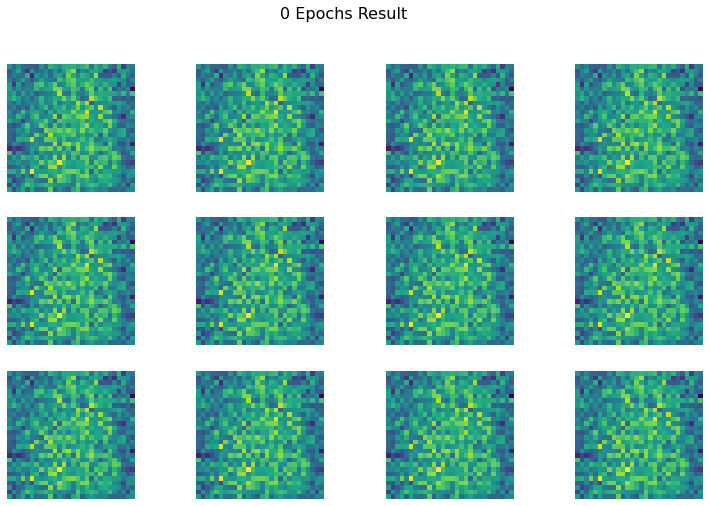

epochs:  20
epochs:  40
epochs:  60
epochs:  80
epochs:  100
Time since start: 542.0


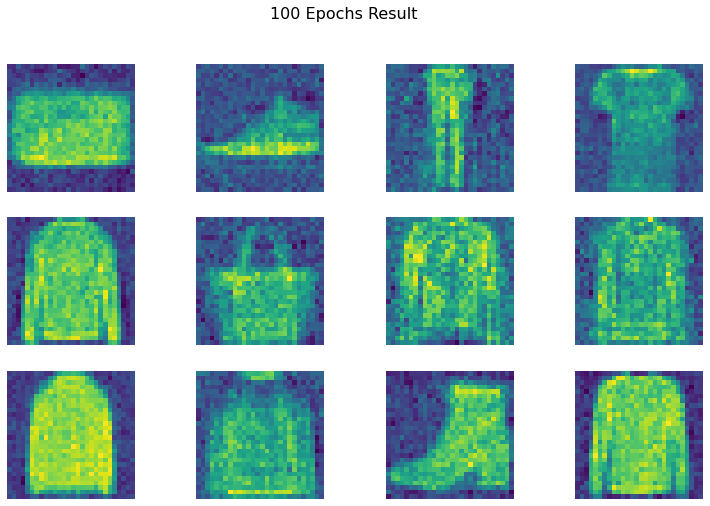

epochs:  120
epochs:  140
epochs:  160
epochs:  180
epochs:  200
Time since start: 1087.0


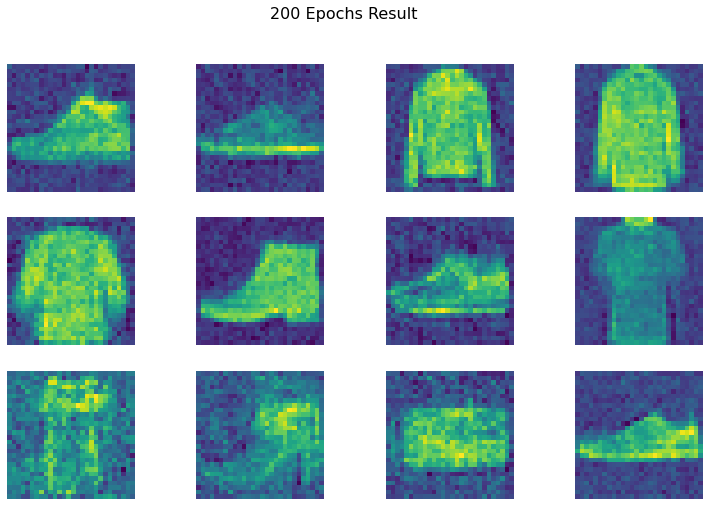

epochs:  220
epochs:  240
epochs:  260
epochs:  280
epochs:  300
Time since start: 1616.0


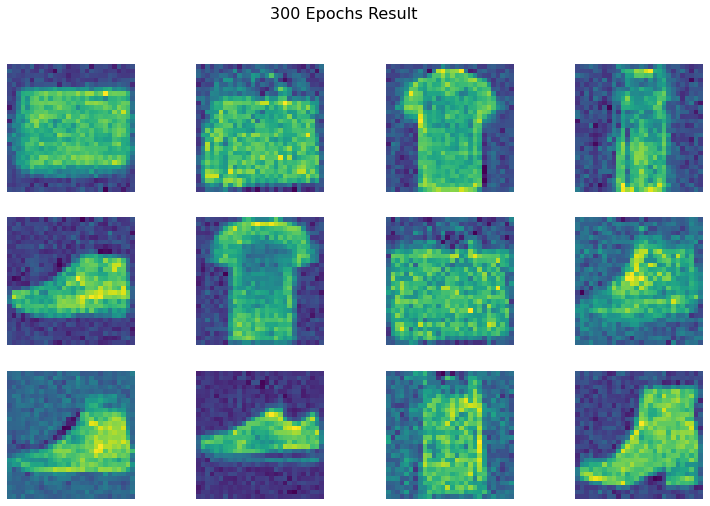

epochs:  320
epochs:  340
epochs:  360
epochs:  380
epochs:  400
Time since start: 2143.0


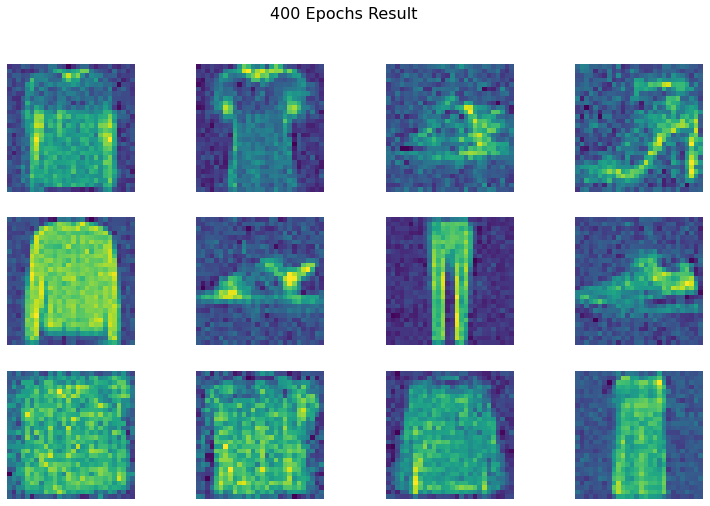

epochs:  420
epochs:  440
epochs:  460
epochs:  480
epochs:  500
Time since start: 2670.0


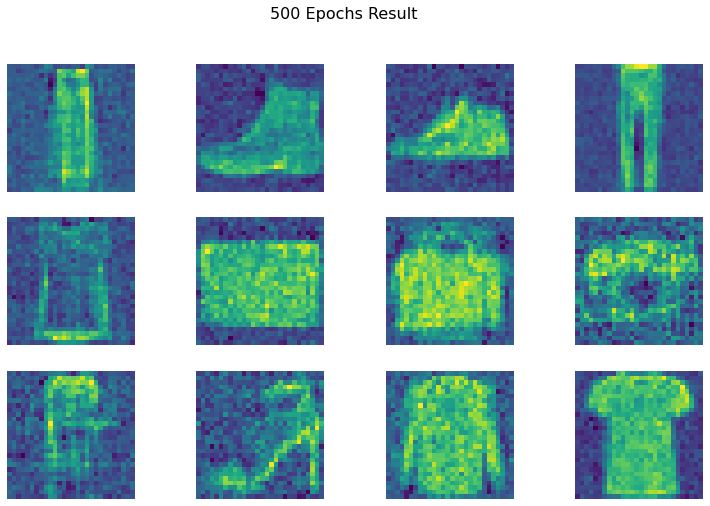

epochs:  520
epochs:  540
epochs:  560
epochs:  580
epochs:  600
Time since start: 3194.0


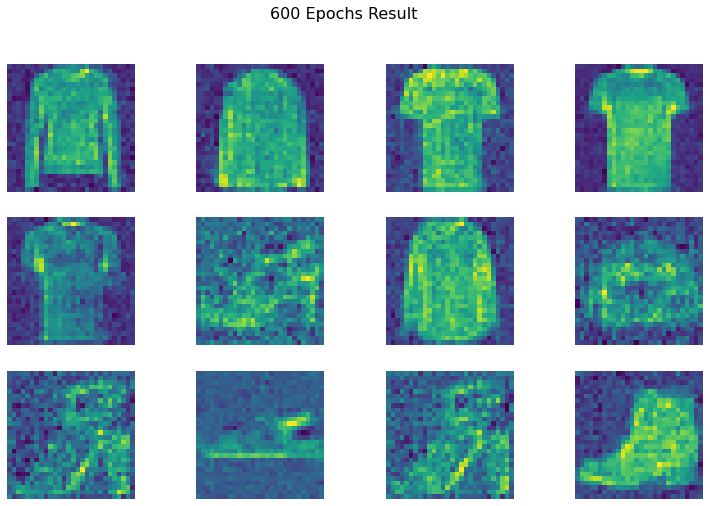

epochs:  620
epochs:  640
epochs:  660
epochs:  680
epochs:  700
Time since start: 3720.0


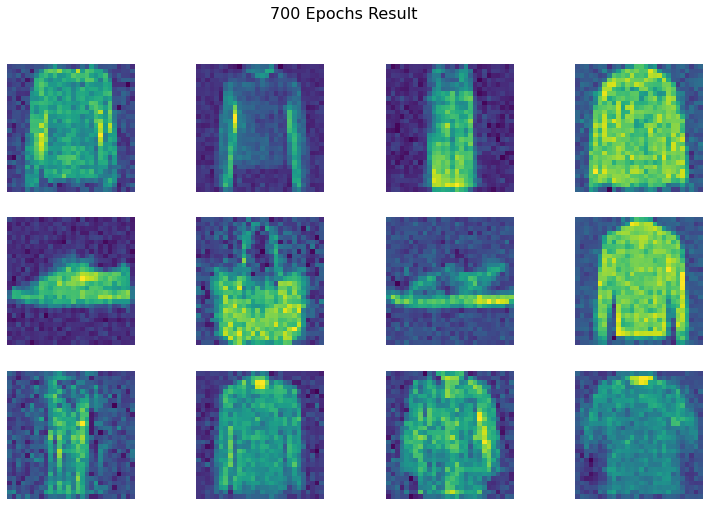

epochs:  720
epochs:  740
epochs:  760
epochs:  780
epochs:  800
Time since start: 4246.0


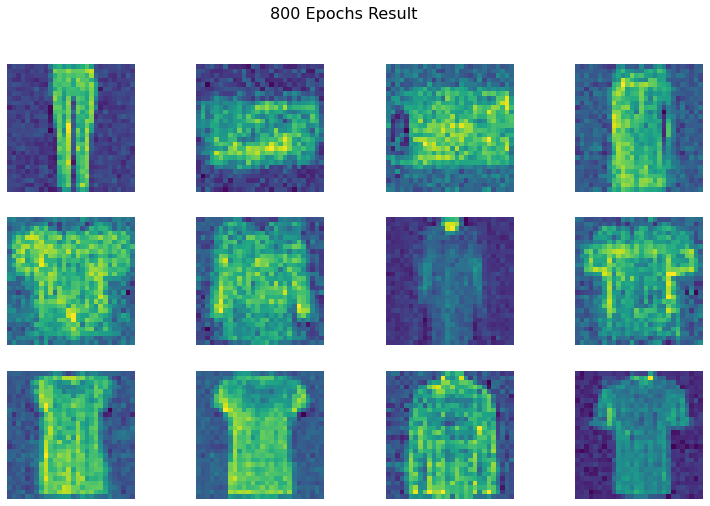

epochs:  820
epochs:  840
epochs:  860
epochs:  880
epochs:  900
Time since start: 4770.0


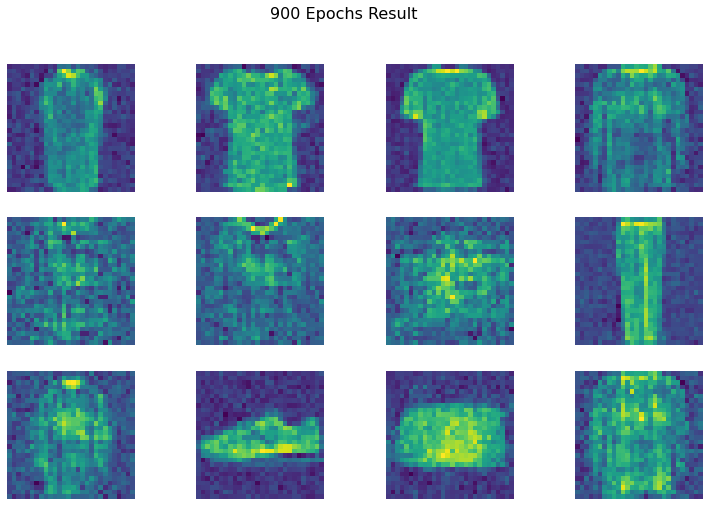

epochs:  920
epochs:  940
epochs:  960
epochs:  980
epochs:  999
Time since start: 5290.0
Training Complete.


In [ ]:
import time

D_loss = []
G_loss = []
epochs = 1000
batch_size = 256
current_time = time.time()

for e in range(epochs):
    start_time = time.time()
    for _ in range(batch_size):
        # I reccomend you to look "Training Diagram" (at the top)
        noise = np.random.normal(0,1, [batch_size,100])

        generated_images = g.predict(noise)

        image_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)] #get samples from real data

        x = np.concatenate([image_batch, generated_images])

        y_dis = np.zeros(batch_size*2)
        y_dis[:batch_size] = 1 # we labeled real images as 1 and generated images as 0

        d.trainable = True
        d_loss = d.train_on_batch(x,y_dis) # we are training discriminator (train_on_batch)

        noise = np.random.normal(0,1,[batch_size,100])

        y_gen = np.ones(batch_size) # our generator says "these images are real"

        d.trainable = False

        g_loss = gan.train_on_batch(noise, y_gen) #train_on_batch

        D_loss.append(d_loss)
        G_loss.append(g_loss)

    if (e%20 == 0) or (e == epochs-1) :
        print("epochs: ",e)
    if e == epochs-1:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        print("Training Complete.")

    # printing results
    if e%100 == 0:
        print("Time since start: {}".format(np.round(start_time - current_time)))

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)

        fig, axs = plt.subplots(3, 4, figsize=(13, 8), sharey=True)
        axs[0,0].imshow(generated_images[66], interpolation = "nearest")
        axs[0,0].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[0,1].imshow(generated_images[66], interpolation = "nearest")
        axs[0,1].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[0,2].imshow(generated_images[66], interpolation = "nearest")
        axs[0,2].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[0,3].imshow(generated_images[66], interpolation = "nearest")
        axs[0,3].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[1,0].imshow(generated_images[66], interpolation = "nearest")
        axs[1,0].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[1,1].imshow(generated_images[66], interpolation = "nearest")
        axs[1,1].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[1,2].imshow(generated_images[66], interpolation = "nearest")
        axs[1,2].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[1,3].imshow(generated_images[66], interpolation = "nearest")
        axs[1,3].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[2,0].imshow(generated_images[66], interpolation = "nearest")
        axs[2,0].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[2,1].imshow(generated_images[66], interpolation = "nearest")
        axs[2,1].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[2,2].imshow(generated_images[66], interpolation = "nearest")
        axs[2,2].axis("off")

        noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
        generated_images = g.predict(noise)
        generated_images = generated_images.reshape(100,28,28)
        axs[2,3].imshow(generated_images[66], interpolation = "nearest")
        axs[2,3].axis("off")

        fig.suptitle("{} Epochs Result".format(str(e)),fontsize=16)
        plt.show()

## Saving and Loading Generator

In [ ]:
from keras import models
g.save("generator_1000epcohs.h5")
generator_save = models.load_model("generator_1000epcohs.h5")

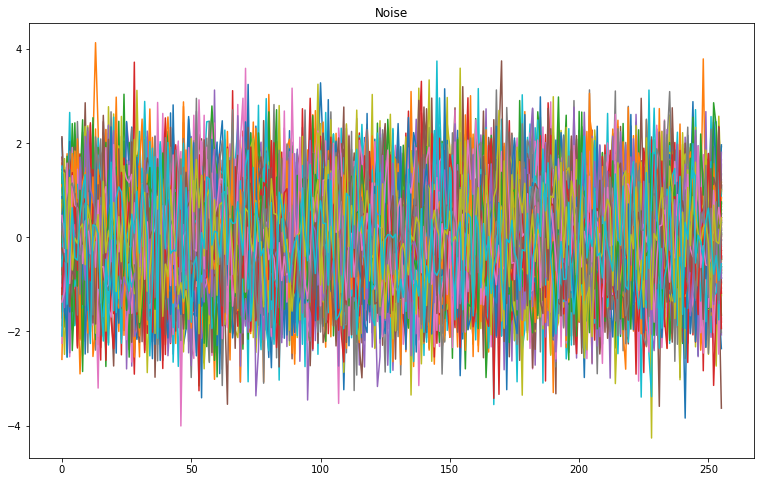

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(noise)
plt.title("Noise")
plt.show()

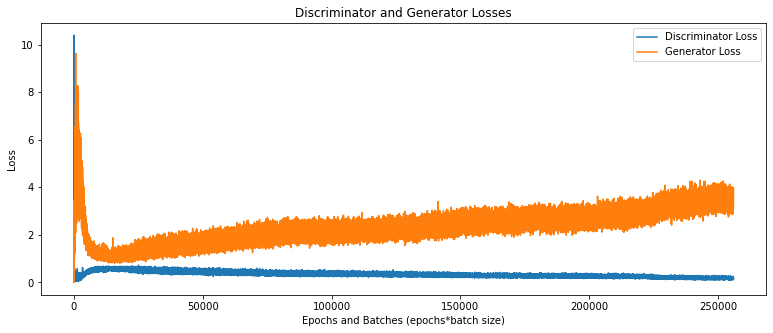

In [ ]:
fig = plt.figure(figsize = (13,5))
plt.plot(D_loss, label = "Discriminator Loss")
plt.plot(G_loss, label = "Generator Loss")
plt.legend()
plt.xlabel("Epochs and Batches (epochs*batch size)")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Losses")

plt.show()

<a id="5"></a> <br>
# Result

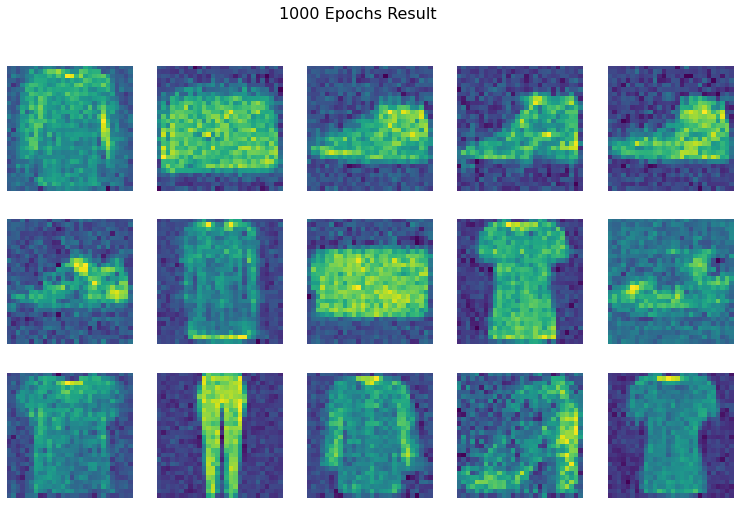

In [ ]:
noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)

fig, axs = plt.subplots(3, 5, figsize=(13, 8), sharey=True)
axs[0,0].imshow(generated_images[66], interpolation = "nearest")
axs[0,0].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[0,1].imshow(generated_images[66], interpolation = "nearest")
axs[0,1].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[0,2].imshow(generated_images[66], interpolation = "nearest")
axs[0,2].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[0,3].imshow(generated_images[66], interpolation = "nearest")
axs[0,3].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[0,4].imshow(generated_images[66], interpolation = "nearest")
axs[0,4].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[1,0].imshow(generated_images[66], interpolation = "nearest")
axs[1,0].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[1,1].imshow(generated_images[66], interpolation = "nearest")
axs[1,1].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[1,2].imshow(generated_images[66], interpolation = "nearest")
axs[1,2].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[1,3].imshow(generated_images[66], interpolation = "nearest")
axs[1,3].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[1,4].imshow(generated_images[66], interpolation = "nearest")
axs[1,4].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[2,0].imshow(generated_images[66], interpolation = "nearest")
axs[2,0].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[2,1].imshow(generated_images[66], interpolation = "nearest")
axs[2,1].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[2,2].imshow(generated_images[66], interpolation = "nearest")
axs[2,2].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[2,3].imshow(generated_images[66], interpolation = "nearest")
axs[2,3].axis("off")

noise = np.random.normal(loc = 0, scale = 1, size=[100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
axs[2,4].imshow(generated_images[66], interpolation = "nearest")
axs[2,4].axis("off")

fig.suptitle("{} Epochs Result".format(str(epochs)),fontsize=16)

plt.show()